In [15]:
from pathlib import Path
import shutil, os, pandas as pd
from collections import defaultdict, Counter

# Parent folder that contains all the split extractions ("Plasmodium-v1", "Plasmodium-v1 2", ..., "Plasmodium-v1 21")
PARENT = Path("/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03")

# Name for the canonical, merged dataset
MERGED = PARENT / "Plasmodium-v1_merged"

# Discover candidate parts
parts = sorted([p for p in PARENT.iterdir() if p.is_dir() and p.name.startswith("Plasmodium-v1") and p != MERGED])
parts


[PosixPath('/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03/Plasmodium-v1'),
 PosixPath('/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03/Plasmodium-v1 10'),
 PosixPath('/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03/Plasmodium-v1 11'),
 PosixPath('/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03/Plasmodium-v1 12'),
 PosixPath('/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03/Plasmodium-v1 13'),
 PosixPath('/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03/Plasmodium-v1 14'),
 PosixPath('/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Ori

In [16]:
xlsx_path, classes_path = None, None
for part in parts:
    if (part/"image_list.xlsx").exists(): xlsx_path = part/"image_list.xlsx"
    if (part/"classes.txt").exists(): classes_path = part/"classes.txt"
    if xlsx_path and classes_path: break
assert xlsx_path and classes_path, "Could not find image_list.xlsx or classes.txt in any part"

df = pd.read_excel(xlsx_path)
assert {"set_name","image_path","species","smear_name","origin"}.issubset(df.columns), df.columns

classes = [c.strip() for c in classes_path.read_text().splitlines() if c.strip()]
num_classes = len(classes)

print("Using:", xlsx_path.parent.name)
print("Splits (xlsx):", df["set_name"].value_counts().to_dict())
print("Classes:", {i:c for i,c in enumerate(classes)})


Using: Plasmodium-v1 2
Splits (xlsx): {'train': 20830, 'test': 4508, 'validation': 3890}
Classes: {0: 'WBC', 1: 'RBC', 2: 'Platelets', 3: 'P. falciparum', 4: 'P. ovale', 5: 'P. malariae', 6: 'P. vivax', 7: 'Babesia', 8: 'Trypanosoma brucei'}


In [17]:
# create lookup: relative path -> absolute source path
img_index, lbl_index = {}, {}

def add_tree(root: Path, sub="images"):
    base = root/sub
    if not base.exists(): return
    for p in base.rglob("*"):
        if p.is_file():
            rel = p.relative_to(root).as_posix()  # e.g., images/train/<smear>/<file>.jpg
            img_index[rel] = p if sub=="images" else img_index.get(rel, None)
    return

def add_labels(root: Path):
    base = root/"labels"
    if not base.exists(): return
    for p in base.rglob("*.txt"):
        rel = p.relative_to(root).as_posix()  # e.g., labels/train/<smear>/<file>.txt
        lbl_index[rel] = p

for part in parts:
    add_tree(part, "images")
    add_labels(part)

print("Indexed images:", len([k for k in img_index if k.startswith("images/")]))
print("Indexed labels:", len(lbl_index))


Indexed images: 33858
Indexed labels: 33827


In [18]:
def img_to_lbl_rel(rel_img):
    # images/.../<smear>/<file>.jpg -> labels/.../<smear>/<file>.txt
    return rel_img.replace("images/","labels/").rsplit(".",1)[0] + ".txt"

missing_imgs, missing_lbls = [], []
found_imgs_in = Counter()
found_lbls_in = Counter()

# map rel path -> which part contains it (for diagnostics)
def which_part(path_abs):
    # find the top-most "Plasmodium-v1*" ancestor
    p = path_abs
    while p.parent != p:
        if p.name.startswith("Plasmodium-v1"): return p.name
        p = p.parent
    return "?"

for rel in df["image_path"]:
    src_img = img_index.get(rel)
    if not src_img:
        missing_imgs.append(rel)
    else:
        found_imgs_in[which_part(src_img)] += 1

    rel_lbl = img_to_lbl_rel(rel)
    src_lbl = lbl_index.get(rel_lbl)
    if not src_lbl:
        missing_lbls.append(rel_lbl)
    else:
        found_lbls_in[which_part(src_lbl)] += 1

print("xlsx total:", len(df))
print("found images:", sum(found_imgs_in.values()), "missing images:", len(missing_imgs))
print("found labels:", sum(found_lbls_in.values()), "missing labels:", len(missing_lbls))
print("Where images were found (by part):", dict(found_imgs_in))
print("Where labels were found (by part):", dict(found_lbls_in))
print("Example missing img:", missing_imgs[:3])
print("Example missing lbl:", missing_lbls[:3])


xlsx total: 29228
found images: 29228 missing images: 0
found labels: 29228 missing labels: 0
Where images were found (by part): {'Plasmodium-v1 19': 1456, 'Plasmodium-v1 10': 1244, 'Plasmodium-v1 8': 1197, 'Plasmodium-v1 9': 1500, 'Plasmodium-v1 14': 1756, 'Plasmodium-v1 3': 1230, 'Plasmodium-v1 5': 1320, 'Plasmodium-v1 21': 1402, 'Plasmodium-v1 12': 1286, 'Plasmodium-v1 11': 963, 'Plasmodium-v1 4': 1074, 'Plasmodium-v1 7': 1622, 'Plasmodium-v1 20': 1358, 'Plasmodium-v1 6': 1252, 'Plasmodium-v1 13': 1370, 'Plasmodium-v1 17': 1624, 'Plasmodium-v1 15': 1271, 'Plasmodium-v1': 1435, 'Plasmodium-v1 16': 1810, 'Plasmodium-v1 18': 1466, 'Plasmodium-v1 2': 1592}
Where labels were found (by part): {'Plasmodium-v1 13': 1082, 'Plasmodium-v1 10': 1933, 'Plasmodium-v1 6': 1187, 'Plasmodium-v1 3': 1475, 'Plasmodium-v1 19': 3460, 'Plasmodium-v1 8': 1325, 'Plasmodium-v1 7': 1657, 'Plasmodium-v1 17': 1302, 'Plasmodium-v1 5': 1900, 'Plasmodium-v1 4': 316, 'Plasmodium-v1 21': 1279, 'Plasmodium-v1 20': 4

In [19]:
MERGED.mkdir(exist_ok=True)
for sub in ["images/train","images/validation","images/test","labels/train","labels/validation","labels/test"]:
    (MERGED/sub).mkdir(parents=True, exist_ok=True)

def safe_link_or_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists(): return
    try:
        os.link(src, dst)   # hardlink (fast, space-efficient)
    except OSError:
        shutil.copy2(src, dst)

# Copy classes.txt & image_list.xlsx for completeness
shutil.copy2(classes_path, MERGED/"classes.txt")
shutil.copy2(xlsx_path, MERGED/"image_list.xlsx")

# Merge files
copied_img, copied_lbl, miss_img, miss_lbl = 0, 0, 0, 0
for rel in df["image_path"]:
    src_img = img_index.get(rel)
    if src_img:
        dst_img = MERGED / rel
        safe_link_or_copy(src_img, dst_img); copied_img += 1
    else:
        miss_img += 1
    rel_lbl = rel.replace("images/","labels/").rsplit(".",1)[0] + ".txt"
    src_lbl = lbl_index.get(rel_lbl)
    if src_lbl:
        dst_lbl = MERGED / rel_lbl
        safe_link_or_copy(src_lbl, dst_lbl); copied_lbl += 1
    else:
        miss_lbl += 1

print("Merged images:", copied_img, "missing:", miss_img)
print("Merged labels:", copied_lbl, "missing:", miss_lbl)


Merged images: 29228 missing: 0
Merged labels: 29228 missing: 0


In [20]:
# quick counts
def count_jpg(p): return sum(1 for _ in p.rglob("*.jpg")) if p.exists() else 0
print("Merged images:", {s: count_jpg(MERGED/"images"/s) for s in ["train","validation","test"]})

# verify that every xlsx image now exists
missing_after = [rel for rel in df["image_path"] if not (MERGED/rel).exists()]
print("Still missing images:", len(missing_after))
if missing_after[:10]: print("Examples:", missing_after[:10])

# verify labels for each xlsx image
def label_path(rel_img): return MERGED / (rel_img.replace("images/","labels/").rsplit(".",1)[0] + ".txt")
missing_lbl_after = [rel for rel in df["image_path"] if not label_path(rel).exists()]
print("Still missing labels:", len(missing_lbl_after))
if missing_lbl_after[:10]: print("Examples:", [label_path(x).relative_to(MERGED).as_posix() for x in missing_lbl_after[:10]])


Merged images: {'train': 20830, 'validation': 3890, 'test': 4508}
Still missing images: 0
Still missing labels: 0


In [21]:
def check_label_file(p, num_classes):
    errs = []
    try:
        for i,line in enumerate(p.read_text().splitlines(), start=1):
            toks = line.strip().split()
            if not toks: continue
            if len(toks) != 5: 
                errs.append(("format", i, line)); continue
            try:
                cls = int(toks[0]); x,y,w,h = map(float, toks[1:])
            except Exception as e:
                errs.append(("parse", i, line)); continue
            if not (0 <= cls < num_classes): errs.append(("cls", i, cls))
            if not (0<=x<=1 and 0<=y<=1 and 0<=w<=1 and 0<=h<=1): errs.append(("norm", i, (x,y,w,h)))
            if w<=0 or h<=0: errs.append(("size", i, (w,h)))
    except Exception as e:
        errs.append(("read", 0, str(e)))
    return errs

bad_files = {}
for rel in df["image_path"]:
    lp = label_path(rel)
    errs = check_label_file(lp, num_classes)
    if errs: bad_files[lp.relative_to(MERGED).as_posix()] = errs

print("Label files with issues:", len(bad_files))
for k,v in list(bad_files.items())[:5]:  # FIXED printing
    print(k, "->", v[:3], "...")


Label files with issues: 0


In [22]:
cls_counter = Counter()
n_boxes = 0
for rel in df["image_path"]:
    lp = label_path(rel)
    for line in lp.read_text().splitlines():
        if not line.strip(): continue
        cls = int(line.split()[0])
        cls_counter[cls] += 1
        n_boxes += 1

print("Total boxes:", n_boxes)
print({classes[k]: v for k,v in cls_counter.most_common()})


Total boxes: 2361785
{'RBC': 2230998, 'Platelets': 58904, 'P. falciparum': 46510, 'Babesia': 5363, 'P. ovale': 5347, 'P. vivax': 4821, 'WBC': 3756, 'P. malariae': 3245, 'Trypanosoma brucei': 2841}


In [23]:
# If any part contains test-zoom, collect it under merged/extra/test-zoom (not used for main experiments)
extra_tz = MERGED/"extra/test-zoom/images"; extra_tz_lbl = MERGED/"extra/test-zoom/labels"
moved = 0
for part in parts:
    tz_img = part/"images/test-zoom"
    tz_lbl = part/"labels/test-zoom"
    if tz_img.exists():
        for p in tz_img.rglob("*.jpg"):
            dst = extra_tz / p.relative_to(tz_img)
            dst.parent.mkdir(parents=True, exist_ok=True)
            if not dst.exists(): shutil.copy2(p, dst); moved += 1
    if tz_lbl.exists():
        for p in tz_lbl.rglob("*.txt"):
            dst = extra_tz_lbl / p.relative_to(tz_lbl)
            dst.parent.mkdir(parents=True, exist_ok=True)
            if not dst.exists(): shutil.copy2(p, dst)
print("Collected test-zoom images:", moved, "(ignored for main experiments)")


Collected test-zoom images: 4539 (ignored for main experiments)


Preprocessiing

In [25]:
from pathlib import Path
import os, shutil, json, csv, warnings
from collections import defaultdict, Counter
import pandas as pd
from PIL import Image, UnidentifiedImageError

# ==== EDIT THESE IF NEEDED ====
# The merged, verified dataset you created:
D3_SRC = Path("/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03/Plasmodium-v1_merged")

# Destination in the same unified layout as D1/D2:
DST_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D3_guemas")

# JPEG save params (images are already .jpg; we will hardlink where possible)
JPEG_QUALITY = 95

# === OUTPUT FOLDERS (match D1/D2) ===
(IM_TRAIN := (DST_DIR/"images/train")).mkdir(parents=True, exist_ok=True)
(IM_VAL   := (DST_DIR/"images/val")).mkdir(parents=True, exist_ok=True)
(IM_TEST  := (DST_DIR/"images/test")).mkdir(parents=True, exist_ok=True)
(ANNO_DIR := (DST_DIR/"annotations")).mkdir(parents=True, exist_ok=True)
(META_DIR := (DST_DIR/"meta")).mkdir(parents=True, exist_ok=True)

# === INPUT FILES ===
XLSX = D3_SRC/"image_list.xlsx"
CLASSES_TXT = D3_SRC/"classes.txt"

assert XLSX.exists() and CLASSES_TXT.exists(), "Missing image_list.xlsx or classes.txt"

print("Source:", D3_SRC)
print("Dest  :", DST_DIR)


Source: /Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/Dataset_03/Plasmodium-v1_merged
Dest  : /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D3_guemas


In [26]:
def read_classes(p: Path):
    return [c.strip() for c in p.read_text().splitlines() if c.strip()]

def write_json(obj, p: Path):
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p,"w") as f: json.dump(obj, f, indent=2)

def log_stats(title, d):
    print(f"\n--- {title} ---")
    for k,v in d.items(): print(f"{k:28s}: {v}")

def hardlink_or_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists(): return
    try:
        os.link(src, dst)
    except OSError:
        shutil.copy2(src, dst)

def img_abs(rel_img: str) -> Path:
    return D3_SRC / rel_img

def lbl_abs_for(rel_img: str) -> Path:
    # images/.../file.jpg -> labels/.../file.txt
    return (D3_SRC / rel_img.replace("images/","labels/")).with_suffix(".txt")

def image_size(p: Path):
    with Image.open(p) as im:
        im.load()
        return im.size  # (w,h)


In [27]:
df = pd.read_excel(XLSX)
assert {"set_name","image_path","species","smear_name","origin"}.issubset(df.columns), df.columns

# Map 'validation' -> 'val' to be consistent with D1/D2
df["split_out"] = df["set_name"].map(lambda s: "val" if s=="validation" else s)

classes = read_classes(CLASSES_TXT)
cls2name = {i:n for i,n in enumerate(classes)}
name2cls = {n:i for i,n in enumerate(classes)}

print("Splits in xlsx:", df["set_name"].value_counts().to_dict())
print("Output splits  :", df["split_out"].value_counts().to_dict())
print("Classes:", cls2name)


Splits in xlsx: {'train': 20830, 'test': 4508, 'validation': 3890}
Output splits  : {'train': 20830, 'test': 4508, 'val': 3890}
Classes: {0: 'WBC', 1: 'RBC', 2: 'Platelets', 3: 'P. falciparum', 4: 'P. ovale', 5: 'P. malariae', 6: 'P. vivax', 7: 'Babesia', 8: 'Trypanosoma brucei'}


In [28]:
# COCO categories — keep RBC, WBC, Platelets, and the two "other parasites"
CATEGORIES = [
    {"id": 1, "name": "RBC"},
    {"id": 2, "name": "WBC"},
    {"id": 3, "name": "Platelets"},
    {"id": 4, "name": "Babesia"},
    {"id": 5, "name": "Trypanosoma brucei"},
]
CAT_ID = {c["name"]: c["id"] for c in CATEGORIES}

# Species set to drive sidecar for infected RBCs
SPECIES_SET = {"P. falciparum","P. vivax","P. ovale","P. malariae"}

# Sidecar attributes (identical keys as D1/D2)
#   infected ∈ {0,1}
#   species ∈ {'falciparum','vivax','ovale','malariae','none'}
#   stage   ∈ {'ring','trophozoite','schizont','gametocyte','none'}  -> always 'none' here
#   quality ∈ {'high','low'} -> 'high' here


In [29]:
def yolo_row_to_xywh_pix(row_tokens, W, H):
    # row_tokens = [cls, x, y, w, h] normalized
    cls = int(row_tokens[0]); x,y,w,h = map(float, row_tokens[1:])
    cx, cy = x*W, y*H
    bw, bh = w*W, h*H
    x0 = max(0, cx - bw/2.0); y0 = max(0, cy - bh/2.0)
    return cls, [int(round(x0)), int(round(y0)), int(round(bw)), int(round(bh))]

def build_split(split_name_in_xlsx, split_out_name, copy_images=True):
    rows = df[df["split_out"]==split_out_name]  # use normalized split

    images, annotations = [], []
    sidecar = defaultdict(dict)
    img_id = 1
    ann_id = 1

    for _, r in rows.iterrows():
        rel_img = r["image_path"]
        abs_img = img_abs(rel_img)
        if not abs_img.exists():
            warnings.warn(f"Missing image: {rel_img}")
            continue

        W,H = image_size(abs_img)
        images.append({"id": img_id, "file_name": Path(rel_img).name, "width": W, "height": H})

        abs_lbl = lbl_abs_for(rel_img)
        if not abs_lbl.exists():
            warnings.warn(f"Missing label: {abs_lbl}")
            img_id += 1
            continue

        lines = [ln.strip().split() for ln in abs_lbl.read_text().splitlines() if ln.strip()]
        for toks in lines:
            cls_idx, xywh = yolo_row_to_xywh_pix(toks, W, H)
            name = cls2name[cls_idx]

            if name == "RBC":
                annotations.append({"id": ann_id, "image_id": img_id, "category_id": CAT_ID["RBC"],
                                    "bbox": xywh, "area": xywh[2]*xywh[3], "iscrowd": 0})
                sidecar[Path(rel_img).name][str(ann_id)] = {
                    "infected": 0, "species": "none", "stage": "none", "quality": "high"
                }
                ann_id += 1

            elif name in SPECIES_SET:
                # infected RBC, species comes from class name
                annotations.append({"id": ann_id, "image_id": img_id, "category_id": CAT_ID["RBC"],
                                    "bbox": xywh, "area": xywh[2]*xywh[3], "iscrowd": 0})
                sp = name.replace("P. ","").lower()  # 'falciparum','vivax','ovale','malariae'
                sidecar[Path(rel_img).name][str(ann_id)] = {
                    "infected": 1, "species": sp, "stage": "none", "quality": "high"
                }
                ann_id += 1

            elif name in ("WBC","Platelets"):
                annotations.append({"id": ann_id, "image_id": img_id, "category_id": CAT_ID[name],
                                    "bbox": xywh, "area": xywh[2]*xywh[3], "iscrowd": 0})
                ann_id += 1

            elif name in ("Babesia","Trypanosoma brucei"):
                annotations.append({"id": ann_id, "image_id": img_id, "category_id": CAT_ID[name],
                                    "bbox": xywh, "area": xywh[2]*xywh[3], "iscrowd": 0})
                ann_id += 1

            else:
                # unexpected class (shouldn't happen)
                pass

        # copy/hardlink image to our unified folder
        if copy_images:
            dst = {"train": IM_TRAIN, "val": IM_VAL, "test": IM_TEST}[split_out_name] / Path(rel_img).name
            hardlink_or_copy(abs_img, dst)

        img_id += 1

    coco = {"images": images, "annotations": annotations, "categories": CATEGORIES}
    return coco, sidecar


In [30]:
COCO_train, SC_train = build_split("train", "train", copy_images=True)
COCO_val,   SC_val   = build_split("validation", "val", copy_images=True)   # note: xlsx 'validation' -> output 'val'
COCO_test,  SC_test  = build_split("test", "test", copy_images=True)

write_json(COCO_train, ANNO_DIR/"coco_train.json")
write_json(SC_train,   ANNO_DIR/"sidecar_train.json")
write_json(COCO_val,   ANNO_DIR/"coco_val.json")
write_json(SC_val,     ANNO_DIR/"sidecar_val.json")
write_json(COCO_test,  ANNO_DIR/"coco_test.json")
write_json(SC_test,    ANNO_DIR/"sidecar_test.json")

log_stats("COCO sizes", {
    "train images": len(COCO_train["images"]), "train ann": len(COCO_train["annotations"]),
    "val images":   len(COCO_val["images"]),   "val ann":   len(COCO_val["annotations"]),
    "test images":  len(COCO_test["images"]),  "test ann":  len(COCO_test["annotations"]),
})


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))



--- COCO sizes ---
train images                : 20830
train ann                   : 1676980
val images                  : 3890
val ann                     : 325546
test images                 : 4508
test ann                    : 359259


In [31]:
# Enums
classes_species = ["falciparum","vivax","ovale","malariae","none"]
classes_stage   = ["ring","trophozoite","schizont","gametocyte","none"]  # always 'none' for D3
write_json(classes_species, META_DIR/"classes_species.json")
write_json(classes_stage,   META_DIR/"classes_stage.json")

# α (inverse-frequency on TRAIN RBC sidecar; exclude 'none')
def counts_from_sidecar(sc, key):
    c = Counter()
    for fname, d in sc.items():
        for annid, attrs in d.items():
            val = attrs.get(key, "none")
            if val != "none": c[val] += 1
    return c

sp_counts = counts_from_sidecar(SC_train, "species")
st_counts = Counter()  # no stage supervision here

def invfreq_alpha(classes, counts):
    eps = 1.0
    weights = {c: (1.0/(counts.get(c,0)+eps)) for c in classes if c!="none"}
    s = sum(weights.values()) or 1.0
    return {c: w/s for c,w in weights.items()}

alpha_species = invfreq_alpha(classes_species, sp_counts)
alpha_stage   = invfreq_alpha(classes_stage,   st_counts)

write_json(alpha_species, META_DIR/"class_weights_species.json")
write_json(alpha_stage,   META_DIR/"class_weights_stage.json")

# split index
with open(META_DIR/"split_index.csv","w",newline="") as f:
    w = csv.writer(f); w.writerow(["image_name","split"])
    for im in COCO_train["images"]: w.writerow([im["file_name"], "train"])
    for im in COCO_val["images"]:   w.writerow([im["file_name"], "val"])
    for im in COCO_test["images"]:  w.writerow([im["file_name"], "test"])

# audit CSV (one row per annotation)
with open(META_DIR/"audit_master.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_name","ann_id","x","y","w","h","category",
                "infected","species","stage","quality","split"])
    def dump(coco, sc, split):
        id2name = {im["id"]: im["file_name"] for im in coco["images"]}
        for ann in coco["annotations"]:
            img_name = id2name[ann["image_id"]]
            x,y,w_,h_ = ann["bbox"]; cid = ann["category_id"]
            cat = next(c["name"] for c in CATEGORIES if c["id"]==cid)
            if cid == CAT_ID["RBC"]:
                attrs = sc[img_name][str(ann["id"])]
                row = [img_name, ann["id"], x,y,w_,h_, cat,
                       attrs["infected"], attrs["species"], attrs["stage"], attrs["quality"], split]
            else:
                row = [img_name, ann["id"], x,y,w_,h_, cat, "", "", "", "", split]
            w.writerow(row)
    dump(COCO_train, SC_train, "train")
    dump(COCO_val,   SC_val,   "val")
    dump(COCO_test,  SC_test,  "test")

print("Meta written →", META_DIR)
print("alpha_species:", alpha_species)
print("alpha_stage:", alpha_stage)


Meta written → /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D3_guemas/meta
alpha_species: {'falciparum': 0.025962196245244817, 'vivax': 0.2897819268001733, 'ovale': 0.24944907643694667, 'malariae': 0.43480680051763526}
alpha_stage: {'ring': 0.25, 'trophozoite': 0.25, 'schizont': 0.25, 'gametocyte': 0.25}


In [36]:
import random, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from PIL import Image

# assumes these already exist from earlier cells
# D3_SRC, df, classes = [...]
SPECIES_SET = {"P. falciparum","P. vivax","P. ovale","P. malariae"}
SPECIES_TAG = {"falciparum":"Pf","vivax":"Pv","ovale":"Po","malariae":"Pm"}

def yolo_label_path(rel_img):
    return (D3_SRC / rel_img.replace("images/","labels/")).with_suffix(".txt")

def yolo_row_to_xywh_pix(tokens, W, H):
    cls = int(tokens[0]); x,y,w,h = map(float, tokens[1:])
    cx, cy = x*W, y*H; bw, bh = w*W, h*H
    x0 = max(0, cx - bw/2.0); y0 = max(0, cy - bh/2.0)
    return cls, [int(round(x0)), int(round(y0)), int(round(bw)), int(round(bh))]

def preview_yolo_direct(split="train", k=12, ncols=4, seed=0, lw=1.5):
    rng = random.Random(seed)
    rows = df[df["set_name"]==("validation" if split=="val" else split)]
    picks = rows.sample(min(k, len(rows)), random_state=seed)

    nrows = math.ceil(len(picks)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 4.2*nrows))
    axes = np.atleast_2d(axes)

    for i, (_, r) in enumerate(picks.iterrows()):
        ax = axes[i//ncols, i%ncols]
        rel_img = r["image_path"]
        img_p = D3_SRC / rel_img
        if not img_p.exists():
            ax.axis('off'); ax.set_title(f"{Path(rel_img).name} (missing)"); continue

        with Image.open(img_p) as im:
            W, H = im.size
            ax.imshow(im)

        lbl_p = yolo_label_path(rel_img)
        inf_cnt = un_cnt = 0
        if lbl_p.exists():
            for line in lbl_p.read_text().splitlines():
                toks = line.strip().split()
                if len(toks) != 5: continue
                cls, xywh = yolo_row_to_xywh_pix(toks, W, H)
                cname = classes[cls]

                if cname == "RBC":
                    color = "green"; un_cnt += 1
                elif cname in SPECIES_SET:
                    color = "red"; inf_cnt += 1
                else:
                    color = "blue"  # WBC/Platelets/Babesia/Trypano

                x,y,w,h = xywh
                ax.add_patch(patches.Rectangle((x,y), w,h, linewidth=lw, edgecolor=color, facecolor='none'))

                if cname in SPECIES_SET:
                    tag = SPECIES_TAG[cname.replace("P. ","").lower()]
                    ax.text(x, max(0,y-2), tag, fontsize=7, color='white',
                            bbox=dict(facecolor='black', alpha=0.35, pad=1))

        ax.set_title(f"{Path(rel_img).name}\nINF={inf_cnt} UN={un_cnt}", fontsize=9)
        ax.axis('off')

    # hide empties
    total = len(picks)
    for j in range(total, nrows*ncols):
        axes[j//ncols, j%ncols].axis('off')

    fig.legend(handles=[
        Patch(edgecolor='red', facecolor='none', label='Infected RBC (Pf/Pv/Po/Pm)'),
        Patch(edgecolor='green', facecolor='none', label='Uninfected RBC'),
        Patch(edgecolor='blue', facecolor='none', label='WBC/Platelets/Other')
    ], loc='lower center', ncol=3, frameon=False)
    plt.tight_layout(rect=[0,0.05,1,1]); plt.show()


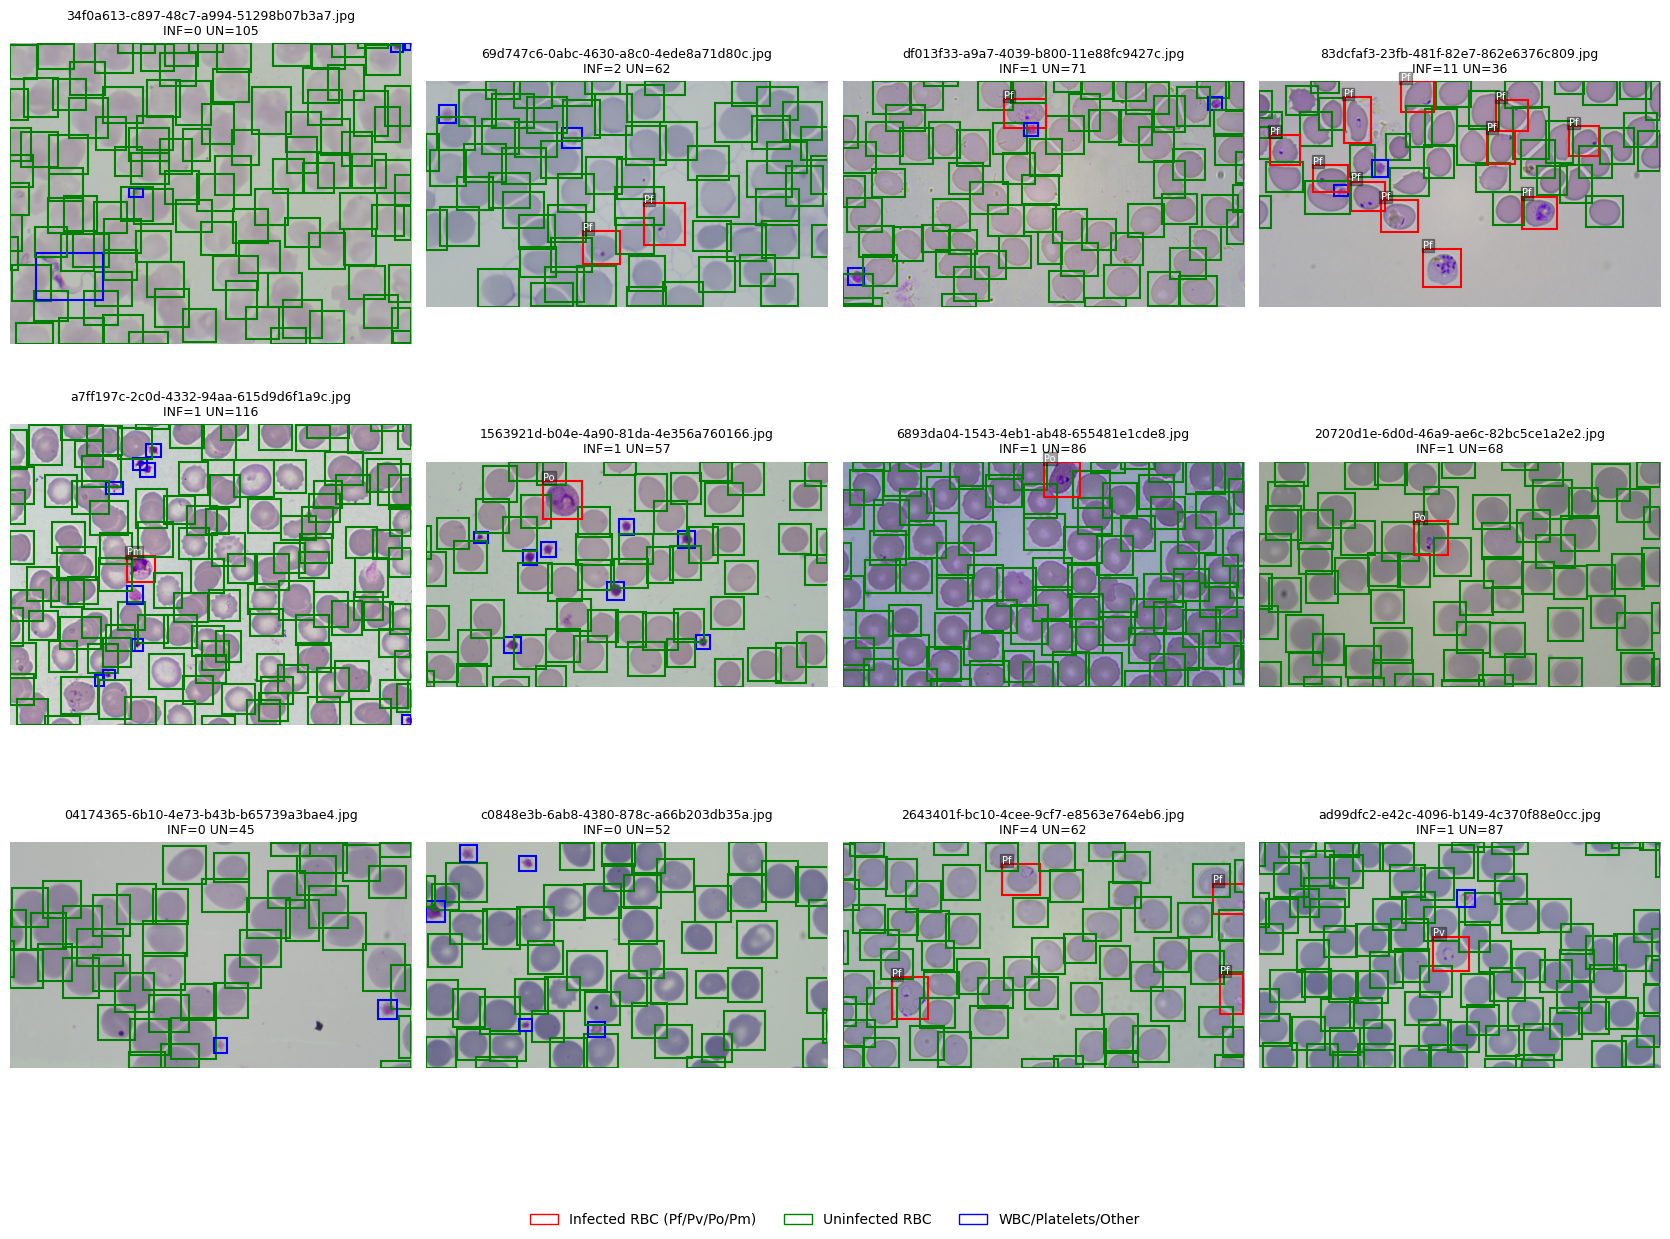

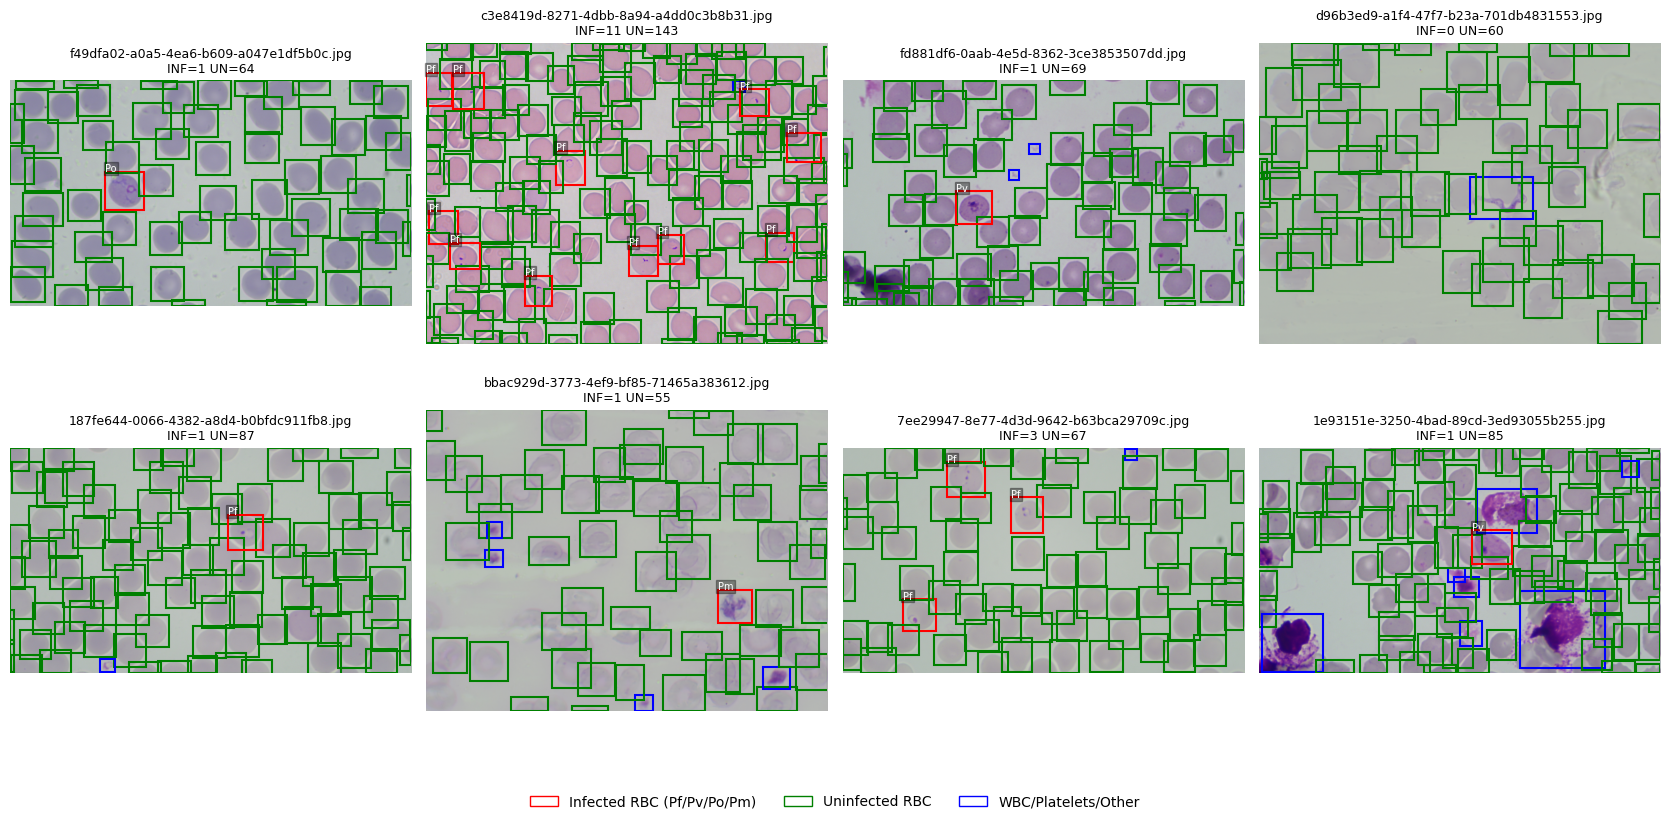

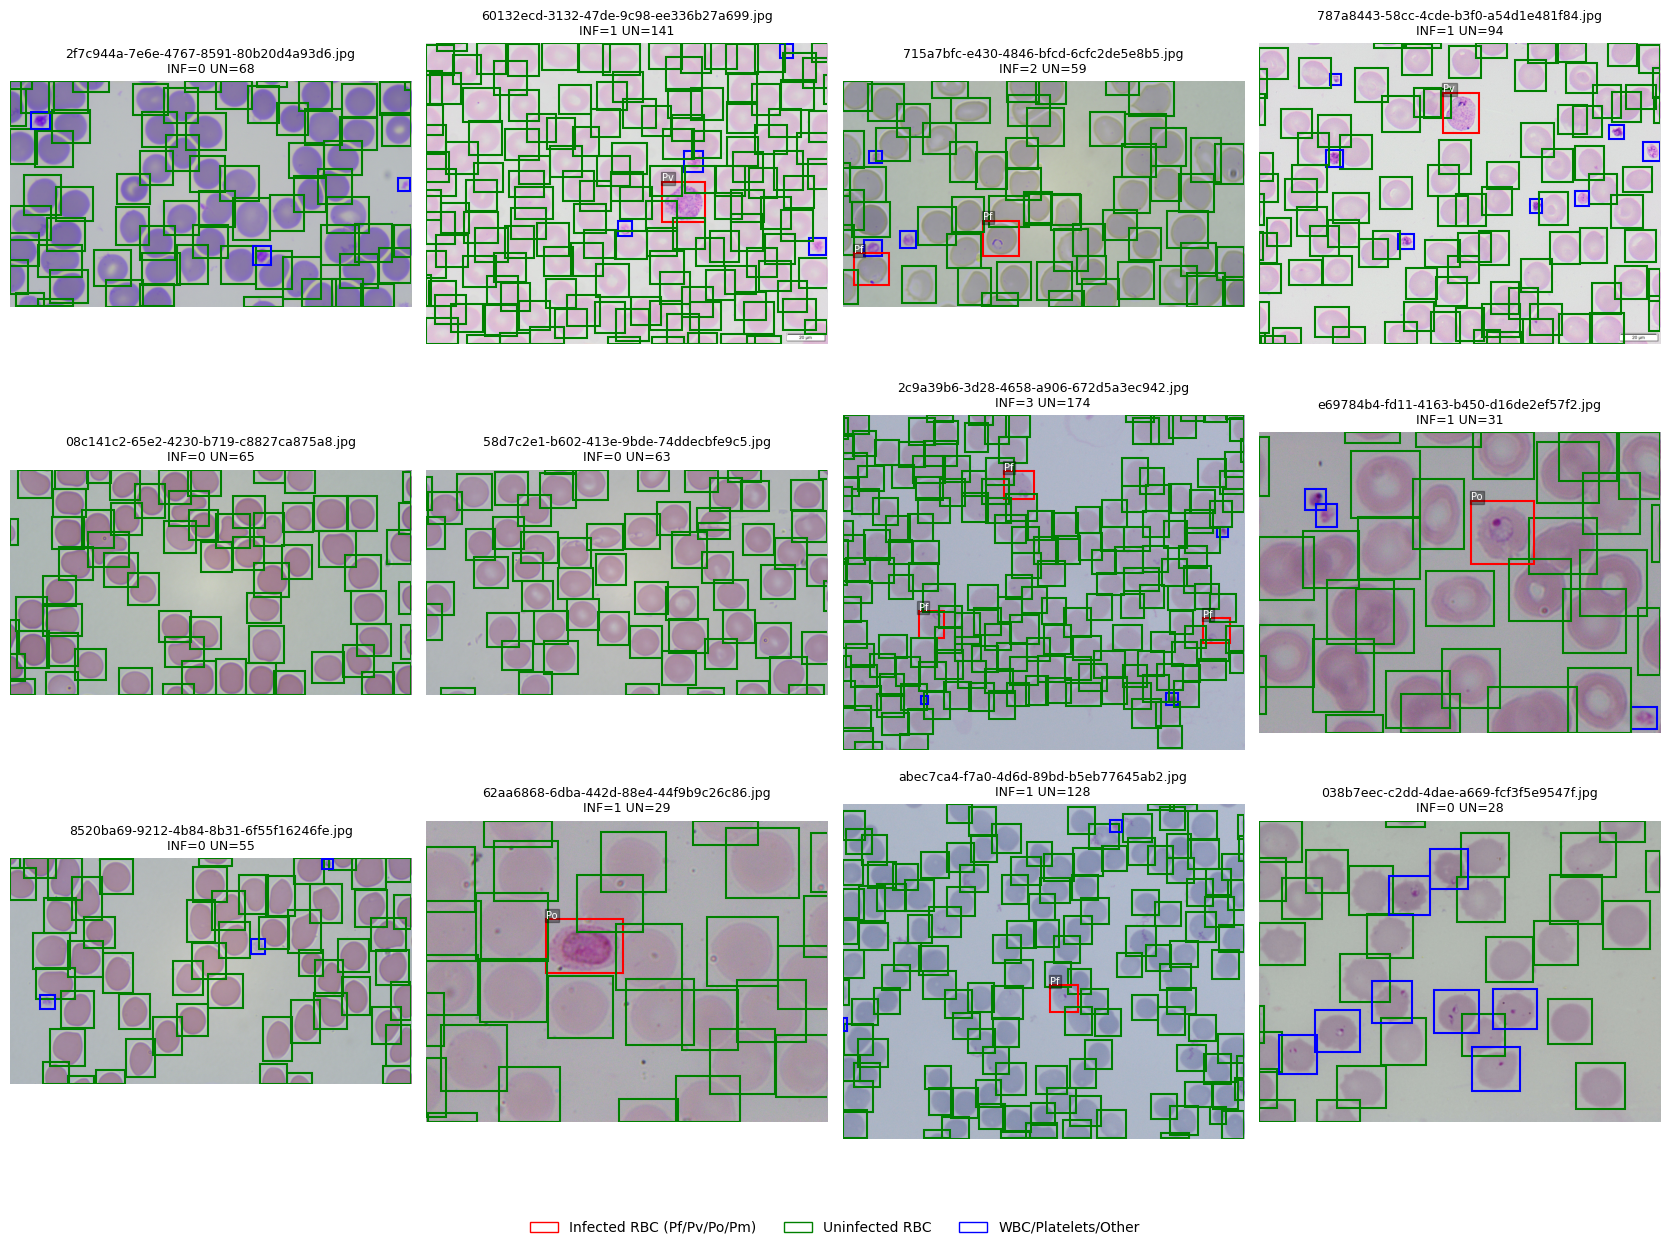

In [37]:
preview_yolo_direct("train", k=12, ncols=4, seed=1)
preview_yolo_direct("val",   k=8,  ncols=4, seed=2)
preview_yolo_direct("test",  k=12, ncols=4, seed=3)


Fixtures

In [38]:
from pathlib import Path

# === Set these to your processed dataset roots (as created for D1/D2/D3) ===
D1_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D1_davidson")
D2_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D2_hung")
D3_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D3_guemas")

DATASETS = {
    "D1_Davidson": D1_DIR,
    "D2_Hung":     D2_DIR,
    "D3_Guemas":   D3_DIR,
}

REPORTS_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)


In [39]:
import json, math
import pandas as pd
from collections import defaultdict, Counter

def rj(p): 
    with open(p,"r") as f: 
        return json.load(f)

def coco_paths(root):
    a = root/"annotations"
    return {
        "train": {"coco": a/"coco_train.json", "sidecar": a/"sidecar_train.json"},
        "val":   {"coco": a/"coco_val.json",   "sidecar": a/"sidecar_val.json"},
        "test":  {"coco": a/"coco_test.json",  "sidecar": a/"sidecar_test.json"},
    }

def species_from_sidecar(attrs):
    # standardized to {'falciparum','vivax','ovale','malariae','none'}
    return attrs.get("species","none")

def stage_from_sidecar(attrs):
    # standardized to {'ring','trophozoite','schizont','gametocyte','none'}
    return attrs.get("stage","none")



In [40]:
def analyze_split(coco, sidecar):
    # build indices
    id2name = {im["id"]: im["file_name"] for im in coco["images"]}
    anns_by_img = defaultdict(list)
    for ann in coco["annotations"]:
        anns_by_img[id2name[ann["image_id"]]].append(ann)

    # which category id is RBC?
    cat_id_by_name = {c["name"]: c["id"] for c in coco["categories"]}
    rbc_id = cat_id_by_name.get("RBC", None)

    # global counters
    n_images = len(coco["images"])
    n_ann    = len(coco["annotations"])

    total_rbc = total_inf = total_un = 0
    species_counter = Counter()
    stage_counter   = Counter()
    per_image_inf_counts = []         # infected RBC count per image
    per_image_rbc_counts = []         # total RBC per image
    per_image_infected_pct = []       # infected / total RBC (per image)

    for img_name, anns in anns_by_img.items():
        # count RBC/INF/UN per image
        rbc = [a for a in anns if a["category_id"] == rbc_id]
        inf = 0
        sp_cnt = Counter()
        st_cnt = Counter()

        for a in rbc:
            attrs = sidecar.get(img_name, {}).get(str(a["id"]), None)
            if not attrs:
                continue
            if int(attrs.get("infected",0)) == 1:
                inf += 1
                species_counter[species_from_sidecar(attrs)] += 1
                sp_cnt[species_from_sidecar(attrs)] += 1
                stage_counter[stage_from_sidecar(attrs)] += 1
                st_cnt[stage_from_sidecar(attrs)] += 1

        un = len(rbc) - inf
        total_rbc += len(rbc); total_inf += inf; total_un += un

        per_image_inf_counts.append(inf)
        per_image_rbc_counts.append(len(rbc))
        per_image_infected_pct.append( (inf/len(rbc)) if len(rbc)>0 else 0.0 )

    # intra-image stats (class imbalance within images)
    import numpy as np
    arr_pct = np.array(per_image_infected_pct, dtype=float) if per_image_infected_pct else np.zeros(0)
    arr_inf = np.array(per_image_inf_counts, dtype=int) if per_image_inf_counts else np.zeros(0, dtype=int)

    intra_stats = {
        "images": n_images,
        "ann": n_ann,
        "RBC": total_rbc,
        "INF": total_inf,
        "UN":  total_un,
        "mean_infected_pct": float(arr_pct.mean()) if arr_pct.size else 0.0,
        "std_infected_pct":  float(arr_pct.std(ddof=0)) if arr_pct.size else 0.0,
        "median_infected_pct": float(np.median(arr_pct)) if arr_pct.size else 0.0,
        "p25_infected_pct": float(np.percentile(arr_pct, 25)) if arr_pct.size else 0.0,
        "p75_infected_pct": float(np.percentile(arr_pct, 75)) if arr_pct.size else 0.0,
        "images_leq2_infected": int((arr_inf <= 2).sum()) if arr_inf.size else 0,
        "images_leq2_infected_pct": float(((arr_inf <= 2).mean())) if arr_inf.size else 0.0,
        "species_counts": dict(species_counter),
        "stage_counts": dict(stage_counter),
    }
    return intra_stats


In [41]:
def inv_freq_alpha(counts_dict, exclude_keys=("none",), eps=1.0):
    # counts_dict: {class_name: count}
    filtered = {k:v for k,v in counts_dict.items() if k not in exclude_keys}
    if not filtered:
        return {}
    inv = {k: 1.0/(v+eps) for k,v in filtered.items()}
    s = sum(inv.values())
    return {k: v/s for k,v in inv.items()}


In [42]:
rows_global = []   # Table A rows
rows_intra  = []   # Table B rows
train_alphas = {}  # per dataset, α_species and α_stage

for dname, root in DATASETS.items():
    paths = coco_paths(root)
    split_objs = {}
    split_stats = {}

    for split in ["train","val","test"]:
        coco_p   = paths[split]["coco"]
        side_p   = paths[split]["sidecar"]
        coco     = rj(coco_p)
        sidecar  = rj(side_p)
        split_objs[split] = (coco, sidecar)

        stats = analyze_split(coco, sidecar)
        split_stats[split] = stats

        # ---- Table A: Global Class Imbalance ----
        # flatten species/stage dicts into consistent columns
        sp = stats["species_counts"]; st = stats["stage_counts"]
        rowA = {
            "Dataset": dname, "Split": split,
            "Images": stats["images"], "Total_Ann": stats["ann"],
            "RBC": stats["RBC"], "Infected": stats["INF"], "Uninfected": stats["UN"],
            "Species_falciparum": sp.get("falciparum",0),
            "Species_vivax":      sp.get("vivax",0),
            "Species_ovale":      sp.get("ovale",0),
            "Species_malariae":   sp.get("malariae",0),
            # stage keys (D1,D2 will have; D3 -> zero/none)
            "Stage_ring":         st.get("ring",0),
            "Stage_trophozoite":  st.get("trophozoite",0),
            "Stage_schizont":     st.get("schizont",0),
            "Stage_gametocyte":   st.get("gametocyte",0),
        }
        rows_global.append(rowA)

        # ---- Table B: Intra-Image Imbalance ----
        rowB = {
            "Dataset": dname, "Split": split, "Images": stats["images"],
            "Infected": stats["INF"], "Uninfected": stats["UN"],
            "Mean Infected %": round(stats["mean_infected_pct"], 6),
            "Std Dev": round(stats["std_infected_pct"], 6),
            "Median Infected %": round(stats["median_infected_pct"], 6),
            "P25 Infected %": round(stats["p25_infected_pct"], 6),
            "P75 Infected %": round(stats["p75_infected_pct"], 6),
            "Images with ≤ 2 Infected": stats["images_leq2_infected"],
            "Images with ≤ 2 Infected %": round(stats["images_leq2_infected_pct"], 6),
        }
        rows_intra.append(rowB)

    # QGFL α from TRAIN only (species & stage)
    sp_train = split_stats["train"]["species_counts"]
    st_train = split_stats["train"]["stage_counts"]
    alpha_species = inv_freq_alpha(sp_train, exclude_keys=("none",))
    alpha_stage   = inv_freq_alpha(st_train, exclude_keys=("none",))
    train_alphas[dname] = {"alpha_species": alpha_species, "alpha_stage": alpha_stage}

# Build DataFrames
df_global = pd.DataFrame(rows_global).sort_values(["Dataset","Split"])
df_intra  = pd.DataFrame(rows_intra).sort_values(["Dataset","Split"])

# Save to CSV
global_csv = REPORTS_DIR/"table_global_imbalance.csv"
intra_csv  = REPORTS_DIR/"table_intra_image_imbalance.csv"
df_global.to_csv(global_csv, index=False)
df_intra.to_csv(intra_csv, index=False)

print("Saved:")
print(" -", global_csv)
print(" -", intra_csv)

# Show compact previews
display(df_global.head(12))
display(df_intra.head(12))

# Also write α tables for quick copy/paste
alpha_rows = []
for dname, alphas in train_alphas.items():
    for k,v in alphas["alpha_species"].items():
        alpha_rows.append({"Dataset": dname, "Type": "species", "Class": k, "Alpha": v})
    for k,v in alphas["alpha_stage"].items():
        alpha_rows.append({"Dataset": dname, "Type": "stage", "Class": k, "Alpha": v})
df_alpha = pd.DataFrame(alpha_rows).sort_values(["Dataset","Type","Class"])
alpha_csv = REPORTS_DIR/"table_qgfl_alphas.csv"
df_alpha.to_csv(alpha_csv, index=False)
print(" -", alpha_csv)
display(df_alpha)


Saved:
 - /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/reports/table_global_imbalance.csv
 - /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/reports/table_intra_image_imbalance.csv


Dataset  Split  Images  Total_Ann      RBC  Infected  Uninfected  \
2  D1_Davidson   test     116       8713     8713       394        8319   
0  D1_Davidson  train     239      24544    24544      1784       22760   
1  D1_Davidson    val      43       3796     3796       199        3597   
5      D2_Hung   test     120       5613     5613        96        5517   
3      D2_Hung  train    1026      66267    66171       830       65341   
4      D2_Hung    val     182      11101    11094       145       10949   
8    D3_Guemas   test    4508     359259   348168      4881      343287   
6    D3_Guemas  train   20830    1676980  1625173     45421     1579752   
7    D3_Guemas    val    3890     325546   317580      9621      307959   

   Species_falciparum  Species_vivax  Species_ovale  Species_malariae  \
2                 394              0              0                 0   
0                1784              0              0                 0   
1                 199              0              0                 0   
5                   0             96              0                 0   
3                   0            830              0                 0   
4                   0            145              0                 0   
8                2965            706            696               514   
6               36241           3246           3771              2163   
7                7304            869            880               568   

   Stage_ring  Stage_trophozoite  Stage_schizont  Stage_gametocyte  
2         105                136             136                 0  
0         500                353             178                 0  
1          57                 27              11                 0  
5          42                 46               2                 5  
3          90                655              57                28  
4          14                112              13                 6  
8           0                  0               0                 0  
6           0                  0               0                 0  
7           0                  0               0                 0

Dataset  Split  Images  Infected  Uninfected  Mean Infected %  \
2  D1_Davidson   test     116       394        8319         0.047201   
0  D1_Davidson  train     239      1784       22760         0.079090   
1  D1_Davidson    val      43       199        3597         0.074092   
5      D2_Hung   test     120        96        5517         0.016044   
3      D2_Hung  train    1026       830       65341         0.011534   
4      D2_Hung    val     182       145       10949         0.011636   
8    D3_Guemas   test    4508      4881      343287         0.013865   
6    D3_Guemas  train   20830     45421     1579752         0.030118   
7    D3_Guemas    val    3890      9621      307959         0.025556   

    Std Dev  Median Infected %  P25 Infected %  P75 Infected %  \
2  0.018484           0.043478        0.035406        0.057037   
0  0.075963           0.044118        0.023529        0.115385   
1  0.057795           0.053435        0.024343        0.129167   
5  0.021823           0.000000        0.000000        0.024390   
3  0.018916           0.000000        0.000000        0.018182   
4  0.019251           0.000000        0.000000        0.018127   
8  0.020852           0.008547        0.000000        0.017544   
6  0.051548           0.013889        0.000000        0.026316   
7  0.049314           0.013158        0.000000        0.020408   

   Images with ≤ 2 Infected  Images with ≤ 2 Infected %  
2                        26                    0.224138  
0                        63                    0.263598  
1                        11                    0.255814  
5                       110                    0.916667  
3                       926                    0.902534  
4                       165                    0.906593  
8                      4086                    0.907597  
6                     16681                    0.812795  
7                      3293                    0.846530

 - /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/reports/table_qgfl_alphas.csv


Dataset     Type        Class     Alpha
0   D1_Davidson  species   falciparum  1.000000
2   D1_Davidson    stage         ring  0.191786
3   D1_Davidson    stage     schizont  0.536787
1   D1_Davidson    stage  trophozoite  0.271426
4       D2_Hung  species        vivax  1.000000
8       D2_Hung    stage   gametocyte  0.536801
6       D2_Hung    stage         ring  0.171068
7       D2_Hung    stage     schizont  0.268400
5       D2_Hung    stage  trophozoite  0.023731
9     D3_Guemas  species   falciparum  0.025962
10    D3_Guemas  species     malariae  0.434807
11    D3_Guemas  species        ovale  0.249449
12    D3_Guemas  species        vivax  0.289782